# Demonstration of the experiment for reproducibility
## Section 7 - Application To Musical Data

Article: "On Orthogonal Projections for Dimension Reduction and Applications in Variational Loss Functions for Learning Problems" <br> Authors: A. Breger, J.I.Orlando, P. Harar, M. Dörfler, S. Klimscha, C. Grechenig, B.S. Gerendas, U. Schmidt-Erfurth, M. Ehler <br> Submitted to: Journal of Mathematical Imaging and Vision https://link.springer.com/journal/10851


# Summary

In this notebook, we prepared the Good Sounds data. All audio files were stripped of the silence using Sox, split into Tukey windowed segments of equal duration according to config parameters. These files were saved to disk and metadata about them were saved to csv_preprocessed.

Next, these segments were splitted into stratified train, validation and test sets with specified number of samples from each class in test and valid sets and the rest of non_leaking segments in train set. Metadata are saved in csv_split.

Segments were transformed into desired time-frequency representation according to csv_split which was shuffled and splitted to batches of equal size with the last batch containing all remaining samples. Batches were saved to disk as .npz files for fast loading. Metadata were saved to batches.csv in appropriate folders.

TimeFrequencySequence object will load and return appropriate batch based on its index. If the batch was removed from disk before initialization of the object, it will be created again.

Then the Fully Convolutional Neural Network model was created in Keras. For hyperparameter optimization, we have used Random search. After that we took 3 of the best performing models and utilized more fine-grained Grid search which yielded the models that we published in the article. The Random Search and Grid search is not included in this notebook. Only the final models are presented. The training logs and weights after each epoch for these 6 models are available in folder ```published_experiments```.

# Outline

1. Config
1. Downloading and preparing the Good Sounds database
1. Preprocessing of the wav files (removing silence and splitting into segments)
1. Splitting into stratified train/validation/test sets
1. Loading split metadata from a file
1. Definition of customized loss function
1. Preparing labels and output-space features for training
1. Creating train/validation/test sequences (and batching)
1. Visualization of some of the training data
1. Definition of the Fully Convolutional Neural Network model
1. Training the model with 6 variations of hyper-parameters
1. Evaluate the experiment outputs

In [ ]:
##############################
# Reproducibility
# In order to be able to reproduce the results we need to set random seeds.
# But, due to usage of multiprocessing and GPU computation it is not possible
# to get the exact same results each time the experiment is run.
# One would need to compute the whole experiment on 1 CPU which is noc feasible.

import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Comment or adjust this to reflect your resources
np.random.seed(1602)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
#############################

# Generic
%matplotlib inline
import zipfile
import pandas as pd
import seaborn as sns
import urllib.request
from src.utils import *
from src.sqlite_to_csv import convert_to_csv
from subprocess import check_output
from multiprocessing import Pool, cpu_count

# DNN
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.initializers import glorot_uniform as gu
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Conv2D, AveragePooling2D, LocallyConnected2D, GlobalMaxPooling2D

# 1. Configuration

In [2]:
# Configure paths
## Here we use relative paths and assume the project root is on SSD drive

paths = {
    # Path to directory where to download the dataset
    'path_download': 'data/',
    
    # Path to directory containing sound-files dir from extracted good-sounds db (ideally on SSD)
    'path_original': 'data/good-sounds/',
    
    # Path to folder where csvs converted from sqlite will be stored
    'path_original_csvs': 'data/database_csvs/',
    
    # Path to csv with list of all audio files will be stored
    'path_csv_original': 'data/good_sounds_meta.csv',
    
    # Path where the train-ready labels for each class reside
    'path_csv_labels': 'data/good_sounds_labels.csv',

    # Path for saving preprocessed files (ideally on SSD otherwise saving can take a long time)
    'path_preprocessed': 'data/preprocessed',
    
    # Path for saving csv of preprocessed files
    'path_csv_preprocessed': 'data/preprocessed/preprocessed.csv',
    
    # Path for saving csv of metadata split into train/valid/test sets
    'path_csv_split': 'data/preprocessed/split.csv',
    
    # Path for saving ready batches for fast loading (on SSD!)
    'path_cache': 'data/batch_cache',
    
    # Path for saving expriment results
    'path_experiments': 'experiments',
}

In [3]:
# Configure wave preprocessing, equalization and splitting parameters

params = {
    # Preparing segments
    'sample_dur_s': 0.5,
    'rate': 48000,  # Output rate of sox silence removal
    'overwrite': False,  # Overwrite previous files on disk during splitting to segments

    # Equalization using variable stride
    # The 'stride_perc' must be either one number or dictionary mapping
    # class names to a float. If one number, uses same stride for all classes.
    # Classes not present in dict will be ommited completely.
    'stride_perc': {'clarinet': 100, 'flute': 73.88, 'trumpet': 62.18, 
                    'violin': 54.13, 'sax_alto': 53.83, 'cello': 45.90},

    'window': True,  # Tukey window with alpha 0.25


    # Splitting
    # Using fixed number of samples for test and valid.
    # All other samples without the leaky ones are used for training.
    'n_valid': 6000,  # per class
    'n_test': 6000,  # per class
}

In [4]:
# Configure time-frequency params

tf_params = {

    # !!!!!!!!!!!!!!!!
    # IF YOU CHANGE TF_PARAMS, MANUALLY REMOVE paths['path_cache'] FOLDER
    # BEFORE CREATING THE SEQUENCES! THEY NEED TO BE RECOMPUTED.
    # !!!!!!!!!!!!!!!!

    'mel': {
        'sr': params['rate'],
        'n_fft': 2048,
        'n_mels': 100,
        'fmin': 0,
        'fmax': params['rate']/2,
        'norm': 1,
        'hop_length': 241
    }
}

In [5]:
# Configure some of the training hyper-parameters

train_params = {
    'batch_size': 128,
    'scaling': 'log',  # One of {None, 'log'}
    'rep': 'mel',  # One of {'raw', mel'}
    'epochs': 20,
    'verbose': 1,

    'shuffle': True,
    'seed': 5610,
    'initial_epoch': 0,
    
    # Set keep_in_ram to True, if training, validation and testing sets together
    # fit in your available RAM. Created batches will be saved to disk anyways.
    # In this case, you need to pregenerate batches before running the training.
    # Each Keras Sequence will load all batches in ramcache and then use those, 
    # which is much faster then even loading from SSD of course.
    'keep_in_ram': True,
    
    # If keep_in_ram is True, turn off multiprocessing and set workers to 1
    'workers': 1,
    'max_queue_size': 10,
    'use_multiprocessing': False,
}

# 2. Downloading and preparing the Good Sounds database

In [9]:
# Download the Good Sounds dataset (13.9 GB)
# We have used the Version 1. of the dataset from 29 Jun 2017
# Website for manual download here: https://zenodo.org/record/820937
# Zip file checksum md5: 2137bbb2d32c1d60aa51e1301225f541

print('Download started ...')
url = 'https://zenodo.org/record/820937/files/good-sounds.zip?download=1'
ensure_folder(paths['path_download'])
urllib.request.urlretrieve(url, os.path.join(paths['path_download'], 'good-sounds.zip'))
print('Download complete.')

Download started ...
Download complete.


In [12]:
# Unpack the archive
print('Unpacking the archive ...')
zf = zipfile.ZipFile(os.path.join(paths['path_download'], 'good-sounds.zip'), 'r')
zf.extractall(path=paths['path_download'])
del zf # Clearing the memory
print('Unpacking complete.')
print('Delete the zip file manually to save space.')

Unpacking the archive ...
Unpacking complete.
Delete the zip file manually to save space.


In [14]:
# Convert sqlite metadata tables into csvs
print('Converting sqlite into csvs ...')
ensure_folder(paths['path_original_csvs'])
convert_to_csv(os.path.join(paths['path_original'], 'database.sqlite'),
               paths['path_original_csvs'])
print('Converting complete.')

Converting sqlite into csvs ...
Converting complete.


In [15]:
# Merge csvs in one with all necessary information
print('Merging metadata into one csv ...')
sounds_csv = pd.read_csv(os.path.join(paths['path_original_csvs'], 'sounds.csv'),
                         usecols=['id', 'instrument'])
sounds_csv.columns = ['sound_id', 'instrument']  # Rename columns
takes_csv = pd.read_csv(os.path.join(paths['path_original_csvs'], 'takes.csv'),
                        usecols=['id', 'sound_id', 'filename'])
takes_csv = takes_csv[['id', 'sound_id', 'filename']]  # Reorder
takes_csv.columns = ['take_id', 'sound_id', 'filename']  # Rename columns
merged = pd.merge(sounds_csv, takes_csv, how='right', on='sound_id')
merged = merged[['take_id', 'sound_id', 'instrument', 'filename']]
merged.to_csv(paths['path_csv_original'], index=False)
del sounds_csv, takes_csv, merged  # Clearing the memory
print('Merging complete.')

Merging metadata into one csv ...
Merging complete.


# 3. Preprocessing of the wav files using multiprocessing

* Removing silence
* Splitting into segments using stride
* Apply Tukey window with alpha=0.25
* Splitting into train, validation, testing sets

### Output: paths['path_csv_preprocessed']

In [16]:
# Load the dataset metadata from a csv file
# Must contain ['take_id', 'sound_id', 'instrument', 'filename'] columns
csv_original = pd.read_csv(paths['path_csv_original'],
                           usecols=['take_id', 'sound_id', 'instrument', 'filename'])
csv_original.head()

take_id  sound_id instrument  \
0        1         1      flute   
1        2         1      flute   
2        3         1      flute   
3        5         2      flute   
4        6         2      flute   

                                            filename  
0  sound_files/flute_almudena_reference/akg/0000.wav  
1  sound_files/flute_almudena_reference/iphone/00...  
2  sound_files/flute_almudena_reference/neumann/0...  
3  sound_files/flute_almudena_reference/akg/0001.wav  
4  sound_files/flute_almudena_reference/iphone/00...

In [19]:
# Run the function prepare segments using multiprocessing
# Takes roughly 260s using AMD Ryzen 8-core cpu and SSD
# Without the SSD, your HDD's speed will be a bottleneck (can take e.g. 25 minutes)

if isinstance(params['stride_perc'], dict):
    # Select only classes that are specified
    csv = csv_original.loc[csv_original['instrument'].isin(
        params['stride_perc'].keys())]
else:
    # Use all classes available
    csv = csv_original

print('Computing...')
pool = Pool(processes=cpu_count())
dfs = pool.starmap(prepare_segments, zip(
    csv.iterrows(), repeat(paths), repeat(params)))

# Concat the results and save them as csv.
csv_preprocessed = pd.concat(dfs)
csv_preprocessed.to_csv(paths['path_csv_preprocessed'], index=False)

print('Done.')

Computing...
Done.


# 4. Splitting into stratified train/validation/test sets

Splitting dataframe into train, valid and test sets with fixed number of n_valid, n_test samples, all the rest non-leaky training samples are used.

**Output: paths['path_csv_split']**

In [21]:
# Load the metadata about audio segments created in previous step
csv_preprocessed = pd.read_csv(paths['path_csv_preprocessed'])
csv_preprocessed.head()

take_id  sound_id instrument  segment_id  \
0        1         1      flute           0   
1        1         1      flute           1   
2        1         1      flute           2   
3        1         1      flute           3   
4        1         1      flute           4   

                                        segment_path  
0  data/preprocessed/sound_files/flute_almudena_r...  
1  data/preprocessed/sound_files/flute_almudena_r...  
2  data/preprocessed/sound_files/flute_almudena_r...  
3  data/preprocessed/sound_files/flute_almudena_r...  
4  data/preprocessed/sound_files/flute_almudena_r...

In [22]:
# sis: helper df for stratification, sis stands for Sound_id segments
sis = csv_preprocessed['sound_id'].value_counts().to_frame(name='segments')
sis = sis.merge(csv_preprocessed[['sound_id', 'instrument']].drop_duplicates(
    subset='sound_id'), how='left', left_index=True, right_on='sound_id')

# Compute the sound_ids for each set

# Test sound_ids
tsi = enough_segments(sis, groupby_col='instrument', segments_col='segments',
                      return_col='sound_id', n=params['n_test'], mode='random')

# Valid sound_ids
vsi = enough_segments(sis.drop(sis.loc[sis['sound_id'].isin(tsi)].index), groupby_col='instrument',
                      segments_col='segments', return_col='sound_id', n=params['n_valid'], mode='random')
vsi = enough_segments(sis[~sis['sound_id'].isin(tsi)], groupby_col='instrument',
                      segments_col='segments', return_col='sound_id', n=params['n_valid'], mode='random')

# Train sound_ids
xsi = sis[~sis['sound_id'].isin(np.concatenate([tsi, vsi]))]['sound_id'].values
assert(len(tsi) + len(vsi) + len(xsi) == len(sis)
       ), 'Not all samples were used. There is bug somewhere.'

# Label everything as train
csv_preprocessed['set'] = 'train'

# Get n samples stratified by column 'instrument' and relabel them as 'test'
test = csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(tsi)].groupby(
    'instrument', group_keys=False).apply(lambda x: x.sample(params['n_test'], random_state=10))
csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(tsi), 'set'] = 'leaky'
csv_preprocessed.loc[test.index, 'set'] = 'test'

# Get other n samples stratified by column 'instrument' and relabel them as 'valid'
valid = csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(vsi)].groupby(
    'instrument', group_keys=False).apply(lambda x: x.sample(params['n_valid'], random_state=10))
csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(vsi), 'set'] = 'leaky'
csv_preprocessed.loc[valid.index, 'set'] = 'valid'

# Save the csv
csv_preprocessed.to_csv(paths['path_csv_split'], index=False)
print('Done.')

Done.


# 5. Loading split metadata from a file

In [6]:
# Open csv with metadata about split segments
csv_split = pd.read_csv(paths['path_csv_split'])
csv_split.head()

take_id  sound_id instrument  segment_id  \
0        1         1      flute           0   
1        1         1      flute           1   
2        1         1      flute           2   
3        1         1      flute           3   
4        1         1      flute           4   

                                        segment_path    set  
0  data/preprocessed/sound_files/flute_almudena_r...  train  
1  data/preprocessed/sound_files/flute_almudena_r...  train  
2  data/preprocessed/sound_files/flute_almudena_r...  train  
3  data/preprocessed/sound_files/flute_almudena_r...  train  
4  data/preprocessed/sound_files/flute_almudena_r...  train

In [7]:
# Get the segments counts of each set as a sanity check
csv_split['set'].value_counts()

train    140722
test      36000
valid     36000
leaky       296
Name: set, dtype: int64

In [8]:
# Get the segments counts of each instrument as a sanity check
csv_split.loc[csv_split['set'] == 'train', 'instrument'].value_counts()

clarinet    24040
flute       23605
trumpet     23410
violin      23300
sax_alto    23218
cello       23149
Name: instrument, dtype: int64

# 6. Definition of customized loss function
The code can be found in function ```custom_loss``` defined in file ```src/utils.py```

# 7. Preparing labels and output-space features for training

* base_labels are used in categorical_crossentropy loss
* features are used in variational loss function

Categorical values are one-hot encoded. Nominal values are normalized so the max value is 1.

In [9]:
# Load labels from a csv
all_features = pd.read_csv(paths['path_csv_labels'], index_col='instrument')
base_labels = ['Y0_clarinet', 'Y0_flute', 'Y0_trumpet',
               'Y0_violin', 'Y0_sax_alto', 'Y0_cello']
labels = all_features[base_labels]
labels

Y0_clarinet  Y0_flute  Y0_trumpet  Y0_violin  Y0_sax_alto  \
instrument                                                              
clarinet              1         0           0          0            0   
flute                 0         1           0          0            0   
trumpet               0         0           1          0            0   
violin                0         0           0          1            0   
sax_alto              0         0           0          0            1   
cello                 0         0           0          0            0   

            Y0_cello  
instrument            
clarinet           0  
flute              0  
trumpet            0  
violin             0  
sax_alto           0  
cello              1

In [10]:
# Additional features for variational loss function
features = all_features.drop(columns=base_labels).values
features

array([[1.     , 0.     , 0.     , 1.     , 0.     , 1.     , 0.     ,
        0.     , 1.     , 0.     , 0.75   , 0.85714, 0.66   , 0.37458,
        0.39548, 0.35163],
       [1.     , 0.     , 0.     , 1.     , 0.     , 0.     , 1.     ,
        0.     , 0.     , 1.     , 1.     , 0.85714, 1.     , 0.59723,
        0.62757, 0.56391],
       [0.     , 1.     , 0.     , 1.     , 0.     , 0.     , 0.     ,
        1.     , 0.     , 1.     , 0.75   , 0.71429, 0.66   , 0.23602,
        0.26312, 0.20627],
       [0.     , 0.     , 1.     , 0.     , 1.     , 0.     , 1.     ,
        0.     , 1.     , 0.     , 0.75   , 1.     , 0.784  , 1.     ,
        1.     , 1.     ],
       [1.     , 0.     , 0.     , 1.     , 0.     , 0.     , 0.     ,
        1.     , 0.     , 1.     , 0.75   , 0.85714, 0.6    , 0.19111,
        0.2168 , 0.16291],
       [0.     , 0.     , 1.     , 0.     , 1.     , 0.     , 1.     ,
        0.     , 1.     , 0.     , 0.5    , 0.71429, 0.26   , 0.23602,
        0.240

In [11]:
# Create a map from one-hot labels back to class names
onehot_to_label = {tuple(value): base_label for base_label, value
                   in zip(labels.index.values, labels[base_labels].values)}
onehot_to_label

{(1, 0, 0, 0, 0, 0): 'clarinet',
 (0, 1, 0, 0, 0, 0): 'flute',
 (0, 0, 1, 0, 0, 0): 'trumpet',
 (0, 0, 0, 1, 0, 0): 'violin',
 (0, 0, 0, 0, 1, 0): 'sax_alto',
 (0, 0, 0, 0, 0, 1): 'cello'}

# 8. Creating train/validation/test sequences

Also creates batches, if not already created.

In [12]:
# In this step we create Keras Sequences for training the neural network. 
# Batches are either created randomly or read from the csv if provided.

# Creating train sequence
train_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                             rep=train_params['rep'], batch_size=train_params['batch_size'],
                             cache_folder=paths['path_cache'], tf_params=tf_params,
                             scaling_func=get_scaling_f(train_params['scaling']), 
                             keep_in_ram=train_params['keep_in_ram'])

# Creating validation sequence
valid_seq = TimeFreqSequence(df=csv_split, set_name='valid', labels_df=labels, class_col='instrument',
                             rep=train_params['rep'], batch_size=train_params['batch_size'],
                             cache_folder=paths['path_cache'], tf_params=tf_params,
                             scaling_func=get_scaling_f(train_params['scaling']), 
                             keep_in_ram=train_params['keep_in_ram'])

# Creating test sequence
test_seq = TimeFreqSequence(df=csv_split, set_name='test', labels_df=labels, class_col='instrument',
                            rep=train_params['rep'], batch_size=train_params['batch_size'], 
                            cache_folder=paths['path_cache'], tf_params=tf_params,
                            scaling_func=get_scaling_f(train_params['scaling']), 
                            keep_in_ram=train_params['keep_in_ram'])

print('Sequences ready ...')

Sequences ready ...


# 9. Visualization of some of the training data

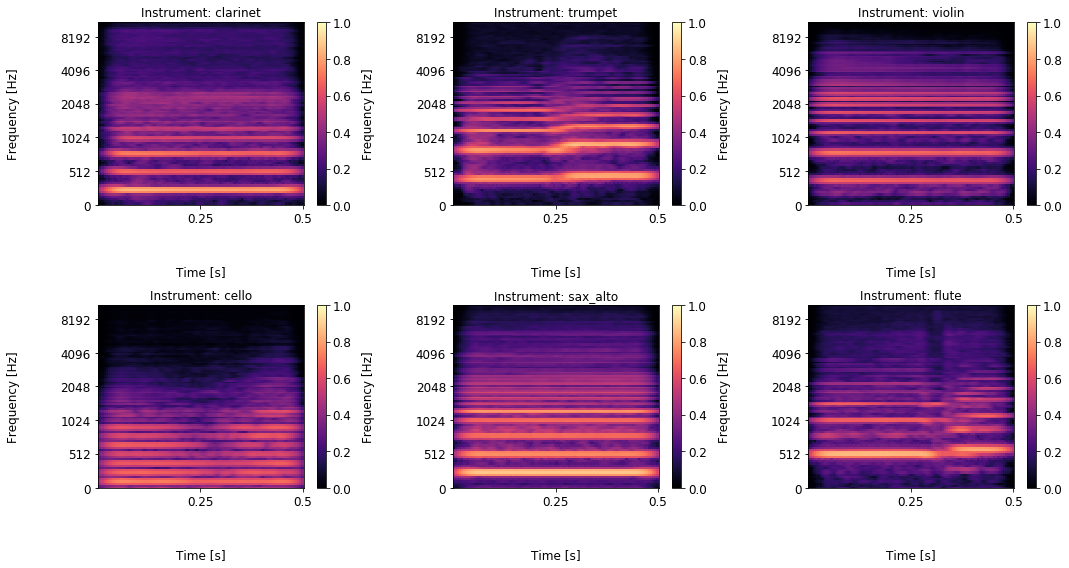

In [15]:
# Plot some training data from batch 10, just for visualization and sanity check.
plt.figure(figsize=(15, 8))
for i, idx in enumerate([0,1,2,3,4,6]):
    plt.tight_layout()
    plt.subplot(2, 3, i+1)

    plot_one_spectrogram(
        train_seq, tf_params['mel'], batch_idx=10, sample_idx=idx, 
        figsize=None, print_stats=False, onehot_to_label=onehot_to_label)

# 10. Definition of the Fully Convolutional Neural Network model

In [13]:
# Definition of the model
def conv(opt='sgd', bn_in=False, nkernel=8, lr=0.001, drop=0.0, 
         kr=0.01, decay=0.0, loss='categorical_crossentropy', 
         seeds=np.arange(20)):
    
    nkernel = int(nkernel)

    inputs = Input(shape=(100, 100), name='input')
    x = Reshape((100, 100, 1), name='reshape-in')(inputs)
    if bn_in:
        BatchNormalization(name='batchnorm-in', axis=-1)(x)

    # Conv stack 01
    x = Conv2D(nkernel, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[0]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_1-1')(x)
    x = Conv2D(nkernel, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[1]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_1-2')(x)

    x = BatchNormalization(name='batchnorm_1-1', axis=-1)(x)
    x = Activation('relu', name='activation_1-1')(x)
    if drop > 0:
        x = Dropout(drop, seed=seeds[1])(x)
    x = AveragePooling2D(pool_size=(2, 2), name='avgpool_1-1')(x)

    # Conv stack 02
    x = Conv2D(nkernel, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[2]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_2-1')(x)
    x = Conv2D(nkernel, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[3]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_2-2')(x)
    x = BatchNormalization(name='batchnorm_2-1', axis=-1)(x)
    x = Activation('relu', name='activation_2-1')(x)
    if drop > 0:
        x = Dropout(drop, seed=seeds[3])(x)
    x = AveragePooling2D(pool_size=(2, 2), name='avgpool_2-1')(x)

    # Conv stack 03
    x = Conv2D(nkernel, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[4]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_3-1')(x)
    x = Conv2D(nkernel, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[5]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_3-2')(x)

    x = BatchNormalization(name='batchnorm_3-1', axis=-1)(x)
    x = Activation('relu', name='activation_3-1')(x)
    if drop > 0:
        x = Dropout(drop, seed=seeds[5])(x)
    x = AveragePooling2D(pool_size=(2, 2), name='avgpool_3-1')(x)

    # Conv stack 04
    x = Conv2D(6, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[6]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_4-1')(x)
    x = Conv2D(6, (3, 3), padding='same', use_bias=False,
               kernel_initializer=gu(seed=seeds[7]),
               kernel_regularizer=regularizers.l2(kr),
               name='conv_4-2')(x)

    x = BatchNormalization(name='batchnorm_4-1', axis=-1)(x)
    x = Activation('relu', name='activation_4-1')(x)
    x = AveragePooling2D(pool_size=(2, 2), name='avgpool_4-1')(x)

    # Global
    x = GlobalMaxPooling2D(name='global-max-pool')(x)
    outputs = Activation('softmax', name='output')(x)

    # Compilation
    m = Model(inputs, outputs)
    from keras.optimizers import SGD

    # Pick the optimizer
    if opt == 'sgd':
        optimizer = SGD(lr=lr, momentum=0.0, decay=decay, nesterov=False)
    elif opt == 'adam':
        optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999,
                         epsilon=None, decay=decay, amsgrad=False)

    m.compile(optimizer, loss=loss, metrics=['accuracy'])
    print(m.summary())
    return m

# 11. Training the model with 6 variations of hyper-parameters

These are the hyperparameters used to train the models presented in the Table 7.1 in the original paper.

You can either start training without pregenerating the batches. Or you can pregenerate them.


<font color='red'>Be aware that the very first epoch will take significantly longer than all others, if you do not pregenerate the batches, since all the batches are being created. If the batches were generated before, let's say on previous run or the previous experiment with the same tf_params, than it is not going to crete the batches again.</font>

In [ ]:
# Pregenerating the batches

st = time.time()
for i in range(train_seq.__len__()):
    train_seq.__getitem__(i)
et = time.time()
print('Train: {:.4f} s | {:.4f} s / batch'.format(et - st, (et - st)/train_seq.__len__()))

st = time.time()
for i in range(valid_seq.__len__()):
    valid_seq.__getitem__(i)
et = time.time()
print('Valid: {:.4f} s | {:.4f} s / batch'.format(et - st, (et - st)/valid_seq.__len__()))

st = time.time()
for i in range(test_seq.__len__()):
    test_seq.__getitem__(i)
et = time.time()
print('Test: {:.4f} s | {:.4f} s / batch'.format(et - st, (et - st)/test_seq.__len__()))

In [ ]:
# Defining the hyper-parameter space
opt = 'sgd'
hyperparameter_space = np.array([
    # 0   , 1    , 2    , 3    , 4    , 5
    [14.00, 14.00, 14.00, 14.00, 14.00, 14.00],    # N kernels
    [5.000, 5.000, 5.000, 5.000, 5.000, 5.000],    # Lr
    [0.910, 0.910, 0.910, 0.910, 0.910, 0.910],    # Decay
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000],    # Dropout
    [0.000, 0.010, 0.010, 0.000, 0.010, 0.010],    # Alpha
    [0.000, 0.000, 0.000, 0.050, 0.050, 0.050],    # Kernel reg
    [None,  None,  6.000, None,  None,  6.000]]).T # N project


# Include some or all space_elements from space
include = range(0, len(hyperparameter_space))

for i, space_element in enumerate(hyperparameter_space):

    variants = [({}, 'reprod')]

    if i in include:
        for variant_params in variants:
            try:
                start = time.time()
                print(
                    'Running experiment {} - {}.'.format(i, variant_params[1]))

                run_experiment(conv, opt, i, train_seq, valid_seq, test_seq,
                               features, train_params, space_element,
                               variant_params[0], variant_params[1], paths)

                print('Total time: {:.2f}s'.format(time.time() - start))

            except Exception as e:
                print('Error')
                print(e)
                 

print('Done.')

# 12. Evaluate the experiment outputs

This will inspect the results saved in the ```paths['path_experiments']``` folder and creates a summary.

In [ ]:
be = best_epochs(paths['path_experiments'], os.path.join(paths['path_experiments'], 'experiment-results.csv'))

___________________________________

# Saved models from the original experiment
#### <font color='red'>Models are saved in ```published_experiments``` folder.</font>

## Displaying the confusion matrix on testing data of the best model

In [26]:
# Best performing model found using random search followed by more fine grained grid search:

# MODEL ID 51
#
# best_epoch = 17
# train_acc = 0.9857
# valid_acc = 0.9822
# test_acc = 0.9833
#
# hyperparameters = {"batch_size": 128, "scaling": "log", "rep": "mel", "epochs": 20,
#                    "nkernel": 14.0, "lr": 5.0, "decay": 0.91, "drop": 0.0,
#                    "alpha": 0.01, "kr": 0.05, "project_n": 6.0}

# Load model
m51 = load_model('published_experiments/exp-0051-2nd/0017.model',
                 custom_objects={'var_loss': custom_loss(features, project_n=6, alpha=0.01)})

# Get y
m51_test_groundtruth = np.argmax(np.concatenate(
    np.array([y for x, y in test_seq])), axis=1)

# Get predictions
m51_test_predictions = np.argmax(m51.predict_generator(test_seq), axis=1)

# Get confusion matrix
cm51 = confusion_matrix(m51_test_groundtruth, m51_test_predictions)

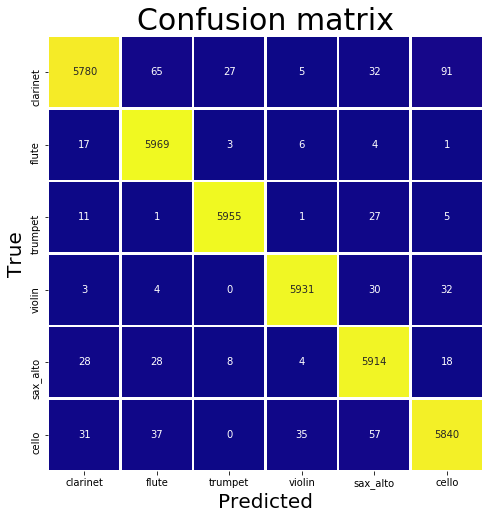

In [116]:
# Plot confusion matrix
plt.figure(figsize=(8,8))
l = ['clarinet', 'flute', 'trumpet', 'violin', 'sax_alto', 'cello']
sns.heatmap(cm51, annot=True, fmt='d', cmap='plasma', cbar=False, 
            linecolor='white', linewidths=1.5, square=True, 
            xticklabels=l, yticklabels=l)
plt.title('Confusion matrix', fontsize=30)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.show(); plt.close()